# Experiment 1

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [36]:
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn, optim
from torchinfo import summary

from plant_village_dataset import PlantVillageDataset
from runner import Runner
from mlp import MLP
from convnext import ConvNext
from encoder_mlp import EncoderMLP
from unet_autoencoder import UNetAutoencoder, UNetEncoder, UNetDecoder

## Prepare Data

In [3]:
BATCH_SIZE = 64

In [4]:
def split(dataset, batch_size, labeled_ratio, test_ratio):    
    labels = np.array([label for _, label in dataset])

    unlabeled_indices, labeled_indices = train_test_split(np.arange(len(dataset)),
                                                          test_size=labeled_ratio,
                                                          stratify=labels)   
    
    ul_train_indices, ul_val_indices = train_test_split(unlabeled_indices, test_size=0.1)
    
    relative_test_ratio = test_ratio / labeled_ratio
    
    train_val_indices, test_indices = train_test_split(labeled_indices,
                                                       test_size=relative_test_ratio,
                                                       stratify=labels[labeled_indices])
    
    train_indices, val_indices = train_test_split(train_val_indices,
                                                  test_size=0.2,
                                                  stratify=labels[train_val_indices])

    ul_train_sampler = SubsetRandomSampler(ul_train_indices)
    ul_val_sampler = SubsetRandomSampler(ul_val_indices)
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    ul_train_loader = DataLoader(dataset, batch_size=batch_size, sampler=ul_train_sampler)
    ul_val_loader = DataLoader(dataset, batch_size=batch_size, sampler=ul_val_sampler)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader

In [5]:
class ReconstructionDataLoader:
    def __init__(self, base_loader):
        self.base_loader = base_loader

    def __iter__(self):
        for data in self.base_loader:
            images, _ = data  # Ignore labels or other types of data
            yield images, images  # Yield images as both input and target

    def __len__(self):
        return len(self.base_loader)

In [6]:
dataset = PlantVillageDataset('images')

Loading Plant Village
<class 'torchvision.datasets.folder.ImageFolder'>
 - Normalizing dataset


 - Calculating mean and standard deviation: 100%|██████████| 434/434 [01:14<00:00,  5.83batch/s]

 - Normalized dataset:
  - Mean: [0.4671, 0.4895, 0.4123]
  - Standard deviation: [0.1709, 0.1443, 0.1880]


In [32]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

## Run 1

In [12]:
ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader = split(dataset, batch_size=BATCH_SIZE, labeled_ratio=0.2, test_ratio=0.1)

ul_train_loader = ReconstructionDataLoader(ul_train_loader)
ul_val_loader = ReconstructionDataLoader(ul_val_loader)

##### CNN

In [52]:
cnn = ConvNext(num_classes=len(dataset.classes))
cnn_optim = optim.Adam(cnn.parameters(), lr=1e-4)
cnn_criterion = nn.CrossEntropyLoss()
cnn_runner = Runner('cnn_1', cnn, cnn_optim, cnn_criterion, device='mps')
cnn_runner.train(train_loader, val_loader, num_epochs=3)
cnn_runner.test(test_loader, idx_to_class)

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 1.9817, Validation Loss: 0.8734


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 2/3 - Train Loss: 0.5793, Validation Loss: 0.3812


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 3/3 - Train Loss: 0.3606, Validation Loss: 0.3640


Testing:   0%|          | 0/87 [00:00<?, ?batch/s]

Test accuracy: 0.9154, Test Loss: 0.3792


##### Autoencoder

In [8]:
uae = UNetAutoencoder()
uae_optim = optim.Adam(uae.parameters(), lr=1e-3)
uae_criterion = nn.MSELoss()
uae_runner = Runner('uae_1', uae, uae_optim, uae_criterion, device='mps')
uae_runner.train(ul_train_loader, ul_val_loader, num_epochs=3)

enc = uae.encoder

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/624 [00:00<?, ?batch/s]

Validating:   0%|          | 0/70 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 0.0271, Validation Loss: 0.0083
Early stopping at epoch 1


##### Frozen Encoder + MLP

Training:   0%|          | 0/5 [00:00<?, ? epoch/s]

Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 1/5 - Train Loss: 2.9459, Validation Loss: 3.1349


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 2/5 - Train Loss: 2.4906, Validation Loss: 2.9947


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 3/5 - Train Loss: 2.3130, Validation Loss: 2.6917


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 4/5 - Train Loss: 2.1801, Validation Loss: 2.8225


Training:   0%|          | 0/70 [00:00<?, ?batch/s]

Validating:   0%|          | 0/18 [00:00<?, ?batch/s]

Epoch 5/5 - Train Loss: 2.1094, Validation Loss: 2.6269


Testing:   0%|          | 0/87 [00:00<?, ?batch/s]

/Users/ariel.arevalo/Workspace/ci0148/proyecto_2/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metric,Value
Loss,2.637591
Accuracy,0.310730
Precision,0.287998
Recall,0.310730


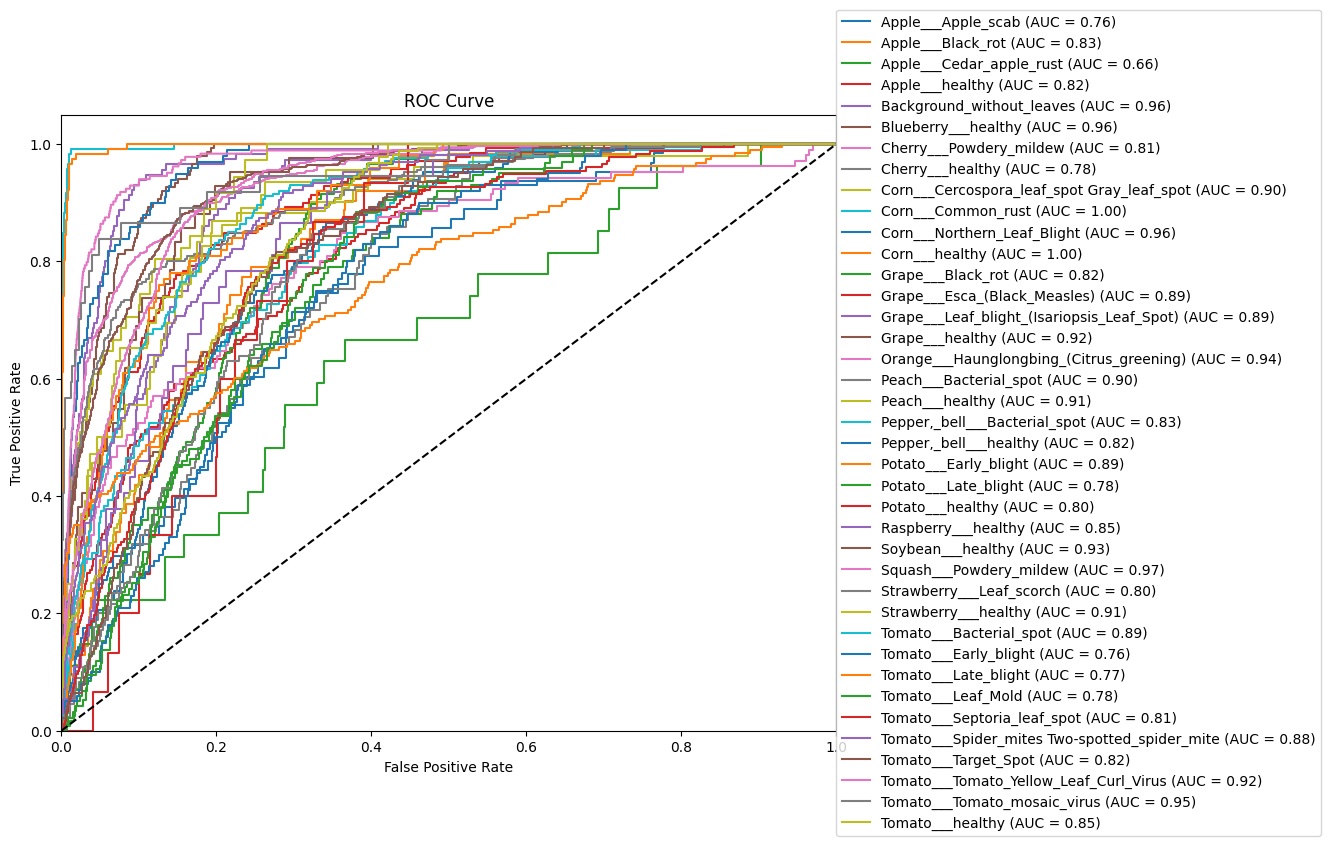

Classification Report:
                                                precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00        63
                            Apple___Black_rot       0.00      0.00      0.00        62
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        27
                              Apple___healthy       0.21      0.15      0.17       164
                    Background_without_leaves       0.31      0.54      0.39       115
                          Blueberry___healthy       0.70      0.13      0.21       150
                      Cherry___Powdery_mildew       0.23      0.10      0.13       105
                             Cherry___healthy       0.00      0.00      0.00        85
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        51
                           Corn___Common_rust       0.65      0.94      0.77       119
                  

/Users/ariel.arevalo/Workspace/ci0148/proyecto_2/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ariel.arevalo/Workspace/ci0148/proyecto_2/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ariel.arevalo/Workspace/ci0148/proyecto_2/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [38]:
mlp = MLP(input_size=512, hidden_sizes=[1024, 512, 256], output_size=len(dataset.classes), dropout_rate=0.3)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=5e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_1_a', emlp, emlp_optim, emlp_criterion, device='mps')
emlp.freeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=5)
emlp_runner.test(test_loader, idx_to_class)

##### Live Encoder + MLP

In [ ]:
mlp = MLP(input_size=512, hidden_sizes=[512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_1_b', emlp, emlp_optim, emlp_criterion, device='mps')
emlp.unfreeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=3)
emlp_runner.test(test_loader, idx_to_class)

##### Cleanup

In [9]:
del ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader
gc.collect()

425

## Run 2

In [10]:
ul_train_loader, ul_val_loader, train_loader, val_loader, test_loader = split(dataset, batch_size=BATCH_SIZE, labeled_ratio=0.5, test_ratio=0.15)

ul_train_loader = ReconstructionDataLoader(ul_train_loader)
ul_val_loader = ReconstructionDataLoader(ul_val_loader)

##### CNN

In [11]:
cnn = ConvNext(num_classes=len(dataset.classes))
cnn_optim = optim.Adam(cnn.parameters(), lr=1e-4)
cnn_criterion = nn.CrossEntropyLoss()
cnn_runner = Runner('cnn_2', cnn, cnn_optim, cnn_criterion, device='mps')
cnn_runner.train(train_loader, val_loader, num_epochs=3)
cnn_runner.test(test_loader, idx_to_class)

Training:   0%|          | 0/3 [00:00<?, ? epoch/s]

Training:   0%|          | 0/243 [00:00<?, ?batch/s]

Validating:   0%|          | 0/61 [00:00<?, ?batch/s]

Epoch 1/3 - Train Loss: 0.9239, Validation Loss: 0.3196


Training:   0%|          | 0/243 [00:00<?, ?batch/s]

KeyboardInterrupt: 

##### Autoencoder

In [ ]:
uae = UNetAutoencoder()
uae_optim = optim.Adam(uae.parameters(), lr=1e-3)
uae_criterion = nn.MSELoss()
uae_runner = Runner('uae_2', uae, uae_optim, uae_criterion, device='mps')
uae_runner.train(ul_train_loader, ul_val_loader, num_epochs=3)

enc = uae.encoder

##### Frozen Encoder + MLP

In [ ]:
mlp = MLP(input_size=512, hidden_sizes=[512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_2_a', emlp, emlp_optim, emlp_criterion, device='mps')
emlp.freeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=3)
emlp_runner.test(test_loader, idx_to_class)

##### Live Encoder + MLP

In [ ]:
mlp = MLP(input_size=512, hidden_sizes=[512, 256], output_size=len(dataset.classes), dropout_rate=0.2)
emlp = EncoderMLP(encoder=enc, mlp=mlp)
emlp_optim = optim.Adam(emlp.parameters(), lr=1e-4)
emlp_criterion = nn.CrossEntropyLoss()
emlp_runner = Runner('emlp_2_b', emlp, emlp_optim, emlp_criterion, device='mps')
emlp.unfreeze_encoder()
emlp_runner.train(train_loader, val_loader, num_epochs=3)
emlp_runner.test(test_loader, idx_to_class)